In [1]:
from copy import deepcopy

import numpy as np 
import matplotlib.pyplot as plt
import torch

In [2]:
def weighted_sample(cumsum): # cumulative distribution in [0, 1]
    r = np.random.random()

    for i in range(cumsum.shape[0]):
        if r < sums[i]:
            return i

In [3]:
class Environment:
    def __init__(self):
        self.pos = 0
        self.score = 0
        self.age = 0

        self.update_represetation()


    def step(self, dir): # "left" or "right"
        prev_pos = self.pos
        moved = False

        if dir == "left":
            if self.pos <= 0:
                pass
            else:
                self.pos -= 1
                moved = True

        elif dir == "right":
            if self.pos >= 5:
                pass
            else:
                self.pos += 1
                moved = True

        if moved:
            if self.pos == 0:
                self.score += 1
            elif self.pos == 5:
                self.score += 10

        self.update_represetation()
        self.age += 1

    def update_represetation(self):
        r = np.zeros((6))
        r[self.pos] = 1
        self.representation = r


In [4]:
class Mind(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

        self.fc1 = torch.nn.Linear(6, 6)
        self.fc2 = torch.nn.Linear(6, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))

        return x

    def mutate(self, lr=0.001):
        child = Mind()

        # copy this network's parameters
        weight_copy = deepcopy(self.state_dict())

        # randomly perturb weights
        for layer in weight_copy:
            weights = weight_copy[layer]
            shape = weights.shape

            r = lr * torch.randn(shape)
            weight_copy[layer] += r

        child.load_state_dict(weight_copy)

        return child

    def simulate(self, steps):
        env = Environment()
        t = 0

        while t < steps:
            # environment to agent
            rep = torch.tensor(env.representation, dtype=torch.float)
            rep = torch.unsqueeze(rep, 0)

            # agent to environment
            action = torch.argmax(self(rep)).item()

            if action == 0:
                env.step('left')
            elif action == 1:
                env.step('right')

            t += 1

        return env.score

In [5]:
population = [Mind() for _ in range(50)]
avg_performance_history = []
high_score_history = []

for _ in range(60):
    # simulate agents in environment and track performance
    scores = []

    for p in population:
        scores.append(p.simulate(50))

    total_score = np.sum(scores)

    avg_performance = total_score/20.0
    avg_performance_history.append(avg_performance)

    high_score = np.max(scores)
    high_score_history.append(high_score)

    # seed next generation by randomly selecting agents weighed by performance
    values = scores / total_score
    sums = np.cumsum(values)

    new_population = []

    for i in range(5):
        ind = weighted_sample(sums)

        for _ in range(4):
            offspring = population[ind].mutate(lr=0.01)
            new_population.append(offspring)

    population = new_population

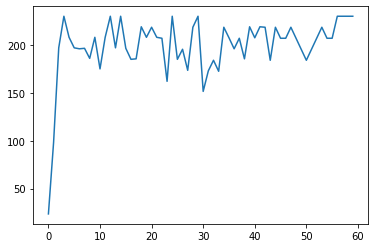

In [6]:
plt.plot(avg_performance_history)